In [169]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from importlib import reload 

#add simulator to a path
sys.path.append('Simulator/')


import estimation_methods as em
import noise_models as nm
import utils as utl  
import simulation as sm
import analyser as anl

%load_ext autoreload
%autoreload 2   





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
def likelihood(x, om, tau, df):
    tau = tau * 2*np.pi
    oms = np.linspace(0,5,201)

    plt.plot(oms,1/2 + x/2*np.cos(df * tau + oms * tau))
    plt.plot(oms,1/2 - x/2*np.cos(df * tau + oms * tau))
    
    return 1/2 + x/2*np.cos(df * tau + om * tau)

def normal_dist(x, mu, sigma):
    return np.exp(-1/2 * (x - mu)**2 / sigma**2)/np.sum(np.exp(-1/2 * (x - mu)**2 / sigma**2))

def prob_update(x, mu, std, t):
    t= 2*np.pi*t
    denom = 1 + x*np.cos(mu*t)*np.exp(-std**2*t**2/2)
    m1 = (mu+x*(mu*np.cos(mu*t)-np.sin(mu*t)*std**2*t
             )*np.exp(-std**2*t**2/2))/denom
    m20 = std**2+mu**2
    m2 = (m20+x*((mu**2+std**2-std**4*t**2)*np.cos(mu*t
          )-2*np.sin(mu*t)*std**2*t*mu
             )*np.exp(-std**2*t**2/2))/denom
    return m1, np.sqrt(m2-m1**2)


def estimate_cycle(noise, mu, std, N_SHOTS, SHOT_TIME, K_ORDER):
    mus = []
    stds = []
    xis = []
    oms = np.linspace(0,5,201)
    for k in range(N_SHOTS):
        plt.figure()
        plt.plot(oms,normal_dist(oms, mu, std)/np.max(normal_dist(oms, mu, std)))
        mu, std = estimate_shot(noise.x, mu, std, get_tau(std), get_df(std, mu, K_ORDER))
        mus.append(mu)
        stds.append(std)
        xis.append(noise.x)
        noise.update(SHOT_TIME)
    return mus, stds, xis

def estimate_shot(om, mu, std, tau, df, rng_shot = np.random.default_rng()):
    p = likelihood(1, om, tau, df)
    x = 2 * np.random.choice(2, p = (1-p,p))-1
    mu, std = prob_update(x, mu, std, tau) 
    return mu, std



def get_df(sig, mu,k):
    # such that 2*pi*(mu+df)*tau = pi/2 + n pi, in case of which p(0) = p(1)
    # tau = 1/n/sig/2
    # df = n*sig
    return 1/4/get_tau(sig) + k/2/get_tau(sig) - mu

def get_tau(sig, n):
    # such that 2pi sig*tau = pi, and width of the filter is sig
    return 1/sig/4

0.0


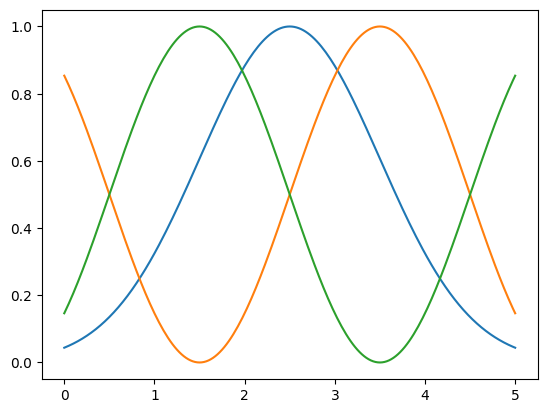

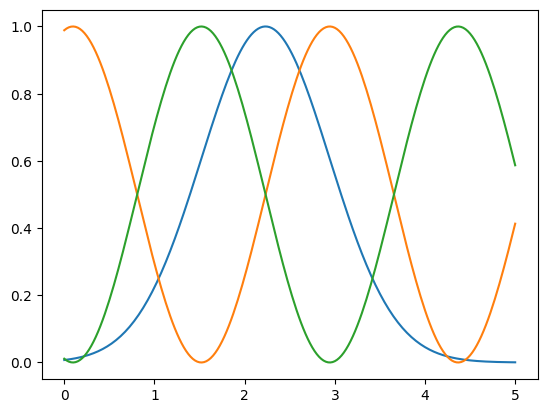

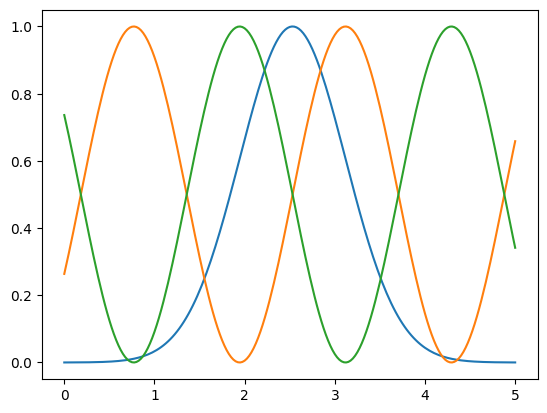

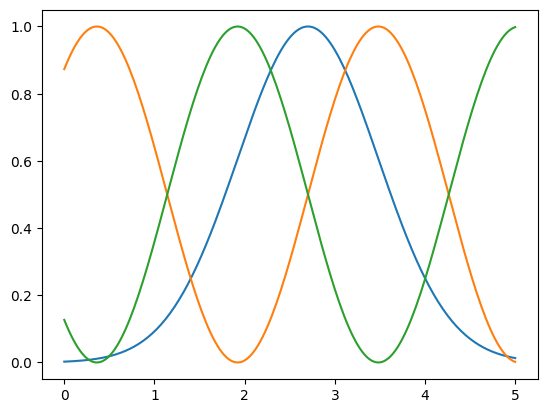

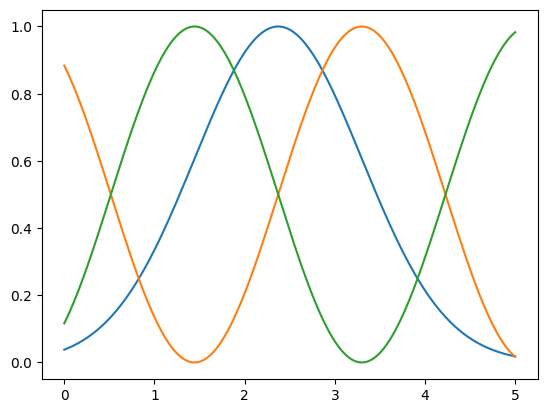

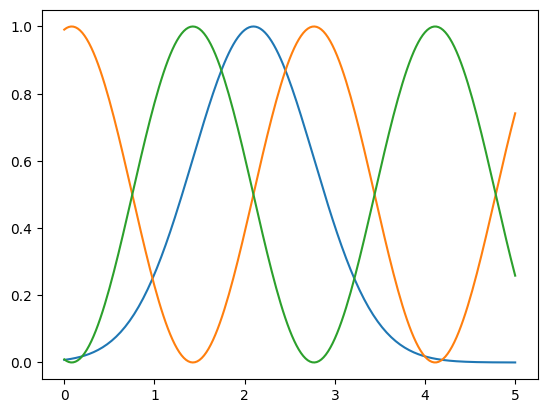

In [203]:
BITS_PER_REPETITIONS = 1
REPETITIONS = 2
phis = [2*np.pi]
bits_est = np.zeros((REPETITIONS, len(phis),BITS_PER_REPETITIONS))
bits_no_est = np.zeros((REPETITIONS,len(phis),BITS_PER_REPETITIONS))
SHOT_TIME = 1e4
N_SHOTS = 3
QUBIT_FREQ = 2 #MHz
K_ORDER = 1

total_time = (N_SHOTS + BITS_PER_REPETITIONS)*REPETITIONS * SHOT_TIME
ommin = 1/1e5
ommax = 1/1e1
N_FLUCTUATORS = 15
noise = nm.Over_f_noise(n_fluctuators = N_FLUCTUATORS, S1  = 1e-9,
                        couplings_dispersion = 1e-99, 
                        ommax = ommax , 
                        ommin = ommin, 
                        om0 = QUBIT_FREQ,
                        fluctuator_class = nm.OrnsteinUhlenbeck)


dom = []
filtered = []
N = 5
mov_avg = 0
mus = [2.5]
sigs = [1]
xis = [noise.x]
for n in range(REPETITIONS):
    if n%100==0:
        print(n/REPETITIONS)
    for pn,phi in enumerate(phis):
        mu, sig, xi = estimate_cycle(noise, mus[-1], sigs[-1], N_SHOTS, SHOT_TIME,K_ORDER)
        mus +=mu
        sigs += sig
        xis += xi

        '''
        if len(est_raw)<N:
            mov_avg = np.average(est_raw)
        else:
            mov_avg = mov_avg + (est_raw[-1] - est_raw[-N])/N
            
        filtered.append(mov_avg)
        for b in range(BITS_PER_REPETITIONS):
            bits_no_est[n,pn,b] = get_bit(10, noise, phi)
            bits_est[n,pn, b] = get_bit(filtered[-1], noise, phi)
        '''


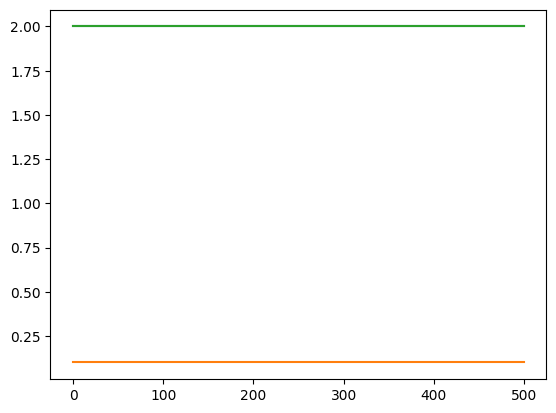

In [151]:
plt.plot(mus)
plt.plot(sigs)
plt.plot(xis)